In [1]:
import glob
import time
import numpy
import crowdsource
import regions
import numpy as np
from functools import cache
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy import wcs
from astropy import table
from astropy import stats
from astropy import units as u
from astropy.nddata import NDData
from astropy.io import fits
from scipy import ndimage
import requests
import requests.exceptions
import urllib3
import urllib3.exceptions
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import IntegratedGaussianPRF, extract_stars, EPSFStars, EPSFModel
try:
    # version >=1.7.0, doesn't work: the PSF is broken
    from photutils.psf import PSFPhotometry, IterativePSFPhotometry, SourceGrouper
except:
    # version 1.6.0, which works
    from photutils.psf import BasicPSFPhotometry as PSFPhotometry, IterativelySubtractedPSFPhotometry as IterativePSFPhotometry, DAOGroup as SourceGrouper
try:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D, LocalBackground
except:
    from photutils.background import MMMBackground, MADStdBackgroundRMS, MedianBackground, Background2D
    from photutils.background import MMMBackground as LocalBackground

from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyDeprecationWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyDeprecationWarning)

from crowdsource import crowdsource_base
from crowdsource.crowdsource_base import fit_im, psfmod

from astroquery.svo_fps import SvoFps

import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

import os
print("Importing webbpsf", flush=True)
import webbpsf
from webbpsf.utils import to_griddedpsfmodel
import datetime

import scipy
import scipy.ndimage
import scipy.spatial
from scipy.spatial import KDTree


Importing webbpsf


In [2]:
filt = filtername = 'f410m'
#filt = filtername = 'f444w'

In [3]:
basepath = '/blue/adamginsburg/adamginsburg/jwst/brick/'

In [4]:
im1 = fits.open(f'{basepath}/F410M/pipeline/jw02221001001_07101_00024_nrcblong_destreak_o001_crf.fits')
#im1 = fits.open(f'{basepath}/F444W/pipeline/jw01182004002_04101_00010_nrcalong_destreak_o004_crf.fits')
obsdate = im1[0].header['DATE-OBS']
ww = wcs.WCS(im1[1].header)

module = 'nrcb'
data = im1['SCI'].data[:400,:400]
err = im1['ERR'].data[:400,:400]

In [5]:
has_downloaded = False
ntries = 0
while not has_downloaded:
    try:
        nrc = webbpsf.NIRCam()
        nrc.load_wss_opd_by_date(f'{obsdate}T00:00:00')
        nrc.filter = filt
        if module in ('nrca', 'nrcb'):
            if 'F4' in filt.upper():
                nrc.detector = f'{module.upper()}5' # I think NRCA5 must be the "long" detector?
            else:
                nrc.detector = f'{module.upper()}1' #TODO: figure out a way to use all 4?
            grid = nrc.psf_grid(num_psfs=16, all_detectors=False, verbose=True, save=True)
        else:
            grid = nrc.psf_grid(num_psfs=16, all_detectors=True, verbose=True, save=True)
        has_downloaded = True
    except (urllib3.exceptions.ReadTimeoutError, requests.exceptions.ReadTimeout, requests.HTTPError) as ex:
        print(f"Failed to build PSF: {ex}", flush=True)
    except Exception as ex:
        print(ex, flush=True)
        if ntries > 10:
            # avoid infinite loops
            raise ValueError("Failed to download PSF, probably because of an error listed above")
        else:
            continue


MAST OPD query around UTC: 2022-08-28T00:00:00.000
                        MJD: 59819.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022082702-NRCA3_FP1-1.fits
	Date (MJD):	 59817.7488
	Delta time:	 -1.2512 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022082902-NRCA3_FP1-1.fits
	Date (MJD):	 59819.7687
	Delta time:	 0.7687 days
User requested choosing OPD time closest in time to 2022-08-28T00:00:00.000, which is R2022082902-NRCA3_FP1-1.fits, delta time 0.769 days
Importing and format-converting OPD from /orange/adamginsburg/jwst/webbpsf-data/MAST_JWST_WSS_OPDs/R2022082902-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point

Running instrument: NIRCam, filter: F410M
  Running detector: NRCB5
    Position 1/16: (0, 0) pixels
    Position 1/16 centroid: (201.50624611033805, 201.04491630614913)
    Position 2/16: (0, 682) pixels
    Position 2/16 centroid: (201.53563193116167, 201.0039664

# PSF check

In [6]:
dao_psf_model = grid
dao_psf_model.flux.min = 0
dao_psf_model

oversample = 1
#proposal_id = 1182
#field = '004'
#proposal_id = 2221
#field = '001'

# don't blur b/c we're using a single frame
#blur_ = ''
#dao_psf_model = to_griddedpsfmodel(f'{basepath}/psfs/{filtername.upper()}_{proposal_id}_{field}_merged_PSFgrid_oversample{oversample}{blur_}.fits')
#dao_psf_model.flux.min = 0

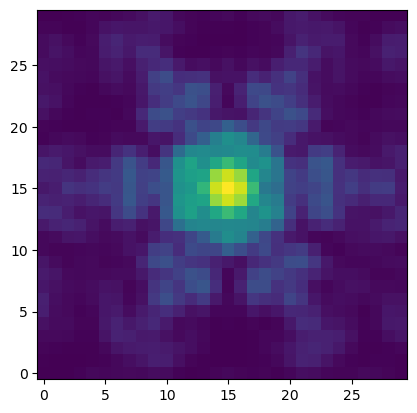

In [7]:
yy, xx = np.mgrid[-15:15,-15:15]
mod_ = dao_psf_model(xx, yy)
pl.imshow(mod_, norm=simple_norm(mod_, stretch='log'));

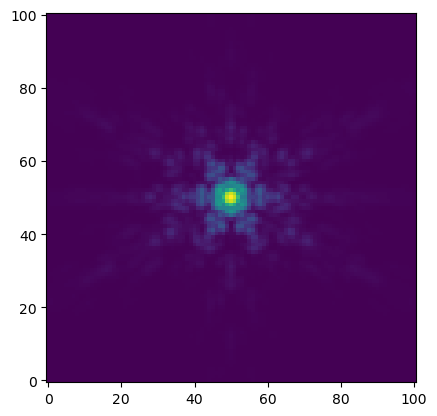

In [8]:
o1 = fits.getdata(f'{basepath}/psfs/F410M_2221_001_merged_PSFgrid_oversample1.fits')
#o1 = fits.getdata(f'{basepath}/psfs/F444W_1182_004_merged_PSFgrid_oversample1.fits')
pl.imshow(o1[0], norm=simple_norm(o1, stretch='log'));

# Start tests

In [9]:
print(f"Starting filter {filtername}", flush=True)
fwhm_tbl = Table.read(f'{basepath}/reduction/fwhm_table.ecsv')
row = fwhm_tbl[fwhm_tbl['Filter'] == filtername.upper()]
fwhm = fwhm_arcsec = float(row['PSF FWHM (arcsec)'][0])
fwhm_pix = float(row['PSF FWHM (pixel)'][0])
fwhm_pix

Starting filter f410m


2.179

In [10]:
grouper = SourceGrouper(2 * fwhm_pix)
mmm_bkg = MMMBackground()

filtered_errest = stats.sigma_clipped_stats(data, stdfunc='mad_std')
print(f'Error estimate for DAO from stats.: {filtered_errest}', flush=True)
filtered_errest = np.nanmedian(err)
print(f'Error estimate for DAO from median(err): {filtered_errest}', flush=True)

Error estimate for DAO from stats.: (11.816186, 11.086611, 4.473108)
Error estimate for DAO from median(err): 0.5934119820594788


In [11]:
daofind_tuned = DAOStarFinder(threshold=5 * filtered_errest,
                              fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                              sharplo=0.30, sharphi=1.40,
                              exclude_border=True
                             )
print("Finding stars with daofind_tuned", flush=True)
finstars = daofind_tuned(np.nan_to_num(data))

print(f"Found {len(finstars)} with daofind_tuned", flush=True)
# for diagnostic plotting convenience
finstars['x'] = finstars['xcentroid']
finstars['y'] = finstars['ycentroid']


Finding stars with daofind_tuned
Found 3304 with daofind_tuned


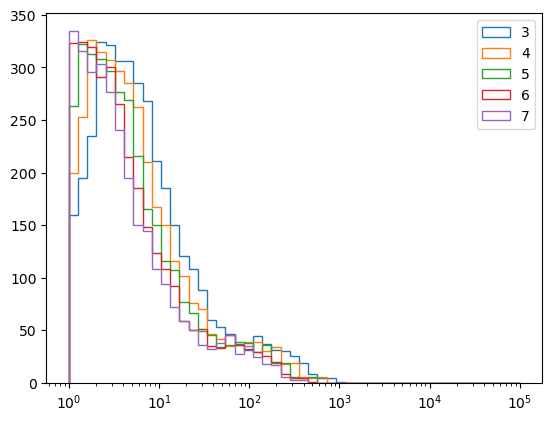

In [12]:
for threshold in (3,4,5,6,7):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=threshold)
pl.xscale('log');
pl.legend(loc='best');

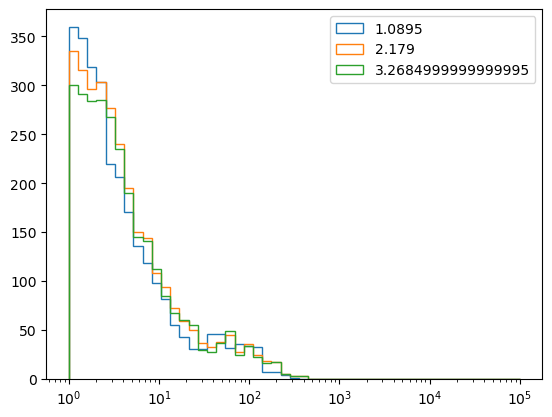

In [13]:
for fwhm in (0.5*fwhm_pix, 1*fwhm_pix, 1.5*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.30, sharphi=1.40,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=fwhm)
pl.xscale('log');
pl.legend(loc='best');

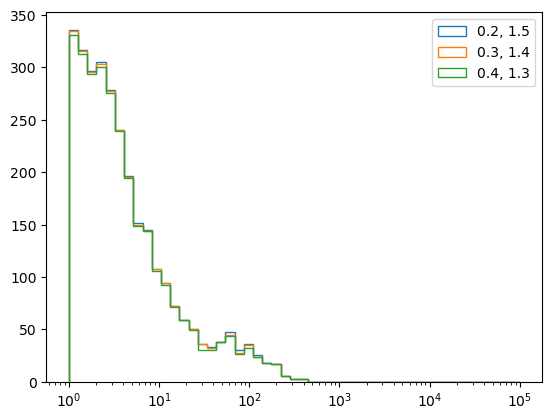

In [14]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

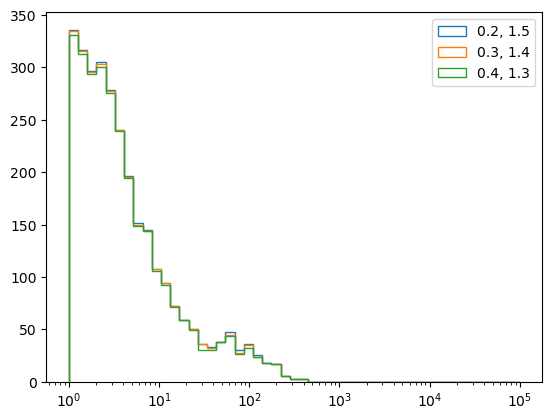

In [15]:
for sharplo, sharphi in ((0.2, 1.5), (0.3, 1.4), (0.4, 1.3)):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=sharplo, sharphi=sharphi,
                                  exclude_border=True
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=f'{sharplo}, {sharphi}')
pl.xscale('log');
pl.legend(loc='best');

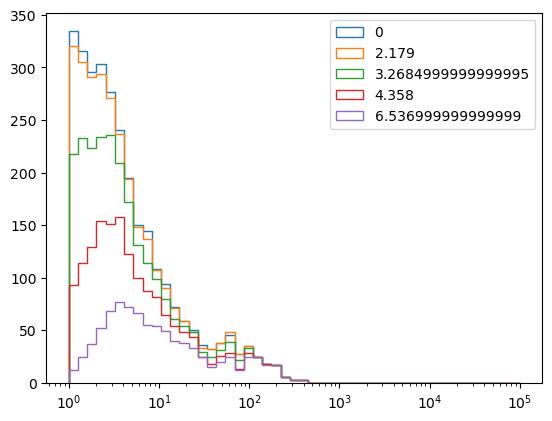

In [16]:
for min_separation in (0, fwhm_pix, 1.5*fwhm_pix, 2*fwhm_pix, 3*fwhm_pix):
    daofind_test = DAOStarFinder(threshold=threshold * filtered_errest,
                                  fwhm=fwhm_pix, roundhi=1.0, roundlo=-1.0,
                                  sharplo=0.3, sharphi=1.4,
                                  exclude_border=True,
                                 min_separation=min_separation,
                                 )
    finstars_test = daofind_test(np.nan_to_num(data))
    pl.hist(finstars_test['flux'], bins=np.logspace(0,5), histtype='step', label=min_separation)
pl.xscale('log');
pl.legend(loc='best');

In [17]:
# I thought that daofind_tuned flux would be flux_init, but this is off by 30x!  That's WAY too much.
daofind_tuned(o1[0]*100)['flux']/100, o1[0].sum()

(<Column name='flux' dtype='float64' length=1>
 0.037745896979898774,
 1.0)

In [18]:
# crowdsource uses inverse-sigma, not inverse-variance
weight = err**-1
maxweight = np.percentile(weight[np.isfinite(weight)], 95)
minweight = np.percentile(weight[np.isfinite(weight)], 5)
badweight =  np.percentile(weight[np.isfinite(weight)], 1)
weight[err < 1e-5] = 0
#weight[(err == 0) | (wht == 0)] = np.nanmedian(weight)
weight[np.isnan(weight)] = 0
bad = np.isnan(weight) | (data == 0) | np.isnan(data) | (weight == 0) | (err == 0) | (data < 1e-5)

weight[weight > maxweight] = maxweight
weight[weight < minweight] = minweight
# it seems that crowdsource doesn't like zero weights
# may have caused broked f466n? weight[bad] = badweight
weight[bad] = minweight
# crowdsource explicitly handles weight=0, so this _should_ work.
weight[bad] = 0

# Expand bad pixel zones for dq
bad_for_dq = ndimage.binary_dilation(bad, iterations=2)
print(f"Total bad pixels = {bad.sum()}, total bad for dq={bad_for_dq.sum()}")

mask = bad

mask = scipy.ndimage.binary_dilation(scipy.ndimage.binary_erosion(mask, iterations=1), iterations=1)
mask = scipy.ndimage.binary_erosion(scipy.ndimage.binary_dilation(mask, iterations=1), iterations=1)

Total bad pixels = 4305, total bad for dq=10942


In [19]:
data.shape, data.size, mask.sum(), bad.sum()

((400, 400), 160000, 3037, 4305)

In [20]:
from scipy.spatial import KDTree

# BASIC

In [21]:
phot = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model,
                     fitter=LevMarLSQFitter(),
                     fit_shape=(5, 5),
                     aperture_radius=2*fwhm_pix,
                     progress_bar=True,
                     xy_bounds=1,
                    )

print("About to do BASIC photometry....")
t0 = time.time()

# mask causes the error 'ValueError: For one or more sources, the number of data points available to fit is less than the number of fit parameters. This could be due to a source(s) near the edge of the detector or if it has few unmasked pixels. Please check the input mask or source positions.'
# for f444w.  This is certainly a bug; daofind shouldn't put stars there.
result = phot(np.nan_to_num(data))#, mask=mask)
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")


About to do BASIC photometry....


Fit source/group:   0%|          | 0/3304 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=3304 dt=191.28252959251404


In [22]:
grouper = SourceGrouper(2 * fwhm_pix)
groups = grouper(finstars['x'], finstars['y'])
np.unique(groups).size, len(finstars), np.bincount(groups).max()

(2095, 3304, 10)

In [23]:
result[:3]

<QTable length=3>
  id  group_id group_size     local_bkg            x_init             y_init           flux_init           x_fit             y_fit            flux_fit            x_err              y_err            flux_err     npixfit        qfit                cfit         flags
int64  int64     int64         float64            float64            float64            float64           float64           float64           float64            float64            float64           float64       int64       float64             float64        int64
----- -------- ---------- ------------------ ------------------ ------------------ ----------------- ----------------- ----------------- ------------------ ------------------ ----------------- ----------------- ------- ------------------ -------------------- -----
    1        1          1  10.26968765258789  6.019413690464192  4.901325190775128 526.7718766423029 5.019413690464192 5.901325190775128 161.77064314575262                nan               nan               nan      25 0.9710067927614304 -0.01565447208715749    32
    2        2          1 13.151541709899902  83.93204077744474 4.4326480219343445 547.3633994774793  83.9069552608124 4.449062514590914 133.62613879490098 0.5716882495915823 0.579142795136685 56.94184173611614      25 1.6545194421281775  0.13473297738068835     0
    3        3          1 14.729190826416016 157.49492245098676   5.16461176863512 924.5411307590531 157.8259343528852  6.16461176863512 163.68582568263255                nan               nan               nan      25 1.1047510223148116  0.03327300432597177    32

In [24]:
residual = phot.make_residual_image(data, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3304 [00:00<?, ?it/s]

In [25]:
model = phot.make_model_image(data.shape, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/3304 [00:00<?, ?it/s]

In [26]:
phot_biggerfootprint = PSFPhotometry(finder=daofind_tuned,#finder_maker(),
                     #grouper=grouper,
                     #localbkg_estimator=None, # must be none or it un-saturates pixels
                     localbkg_estimator=LocalBackground(5, 15),
                     psf_model=dao_psf_model,
                     fitter=LevMarLSQFitter(),
                     fit_shape=(7, 7),
                     aperture_radius=2.2*fwhm_pix,
                     progress_bar=True,
                                     xy_bounds=1
                    )

print("About to do BASIC photometry....")
t0 = time.time()
try:
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data), mask=mask)
except Exception as ex:
    print(ex)
    result_biggerfootprint = phot_biggerfootprint(np.nan_to_num(data))
model_biggerfootprint = phot_biggerfootprint.make_model_image(data.shape, (31, 31), include_localbkg=False)
residual_biggerfootprint = data - model_biggerfootprint
print(f"Done with BASIC photometry.  len(result)={len(result)} dt={time.time() - t0}")


About to do BASIC photometry....


Fit source/group:   0%|          | 0/3304 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/3304 [00:00<?, ?it/s]

Done with BASIC photometry.  len(result)=3304 dt=95.97863984107971


In [27]:
dist, ind = KDTree(np.array([result['x_fit'], result['y_fit']]).T).query(np.array([result['x_fit'], result['y_fit']]).T, 2) 
close_neighbor = ind[:,1][dist[:,1] < 1]

#dist, ind = KDTree(np.array([result_g['x_fit'], result_g['y_fit']]).T).query(np.array([result_g['x_fit'], result_g['y_fit']]).T, 2) 
#close_neighbor_g = ind[:,1][dist[:,1] < 1]

dist, ind = KDTree(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T).query(np.array([result_biggerfootprint['x_fit'], result_biggerfootprint['y_fit']]).T, 2) 
close_neighbor_biggerfootprint = ind[:,1][dist[:,1] < 1]

len(close_neighbor), len(close_neighbor_biggerfootprint)# len(close_neighbor_g),

(223, 240)

In [28]:
close_neighbor_biggerfootprint.shape

(240,)

### Default

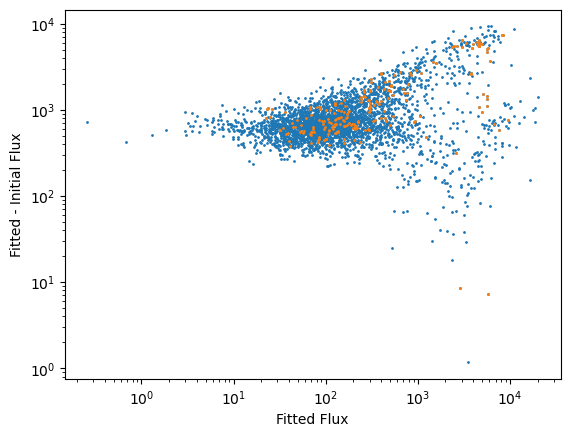

In [29]:
pl.scatter(result['flux_fit'], np.abs(result['flux_fit'] - result['flux_init']), s=1)
pl.scatter(result['flux_fit'][close_neighbor], np.abs(result['flux_fit'] - result['flux_init'])[close_neighbor], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

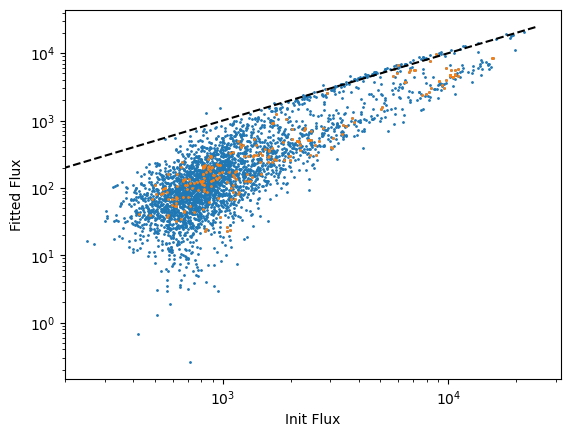

In [30]:
pl.scatter(result['flux_init'], result['flux_fit'] , s=1)
pl.scatter(result['flux_init'][close_neighbor], result['flux_fit'][close_neighbor] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

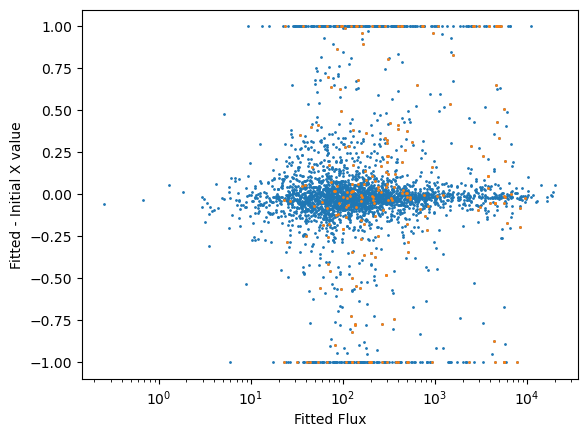

In [31]:
pl.scatter(result['flux_fit'], result['x_fit'] - result['x_init'], s=1)
pl.scatter(result['flux_fit'][close_neighbor], (result['x_fit'] - result['x_init'])[close_neighbor], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.semilogx();

### Grouped

### Bigger Footprint

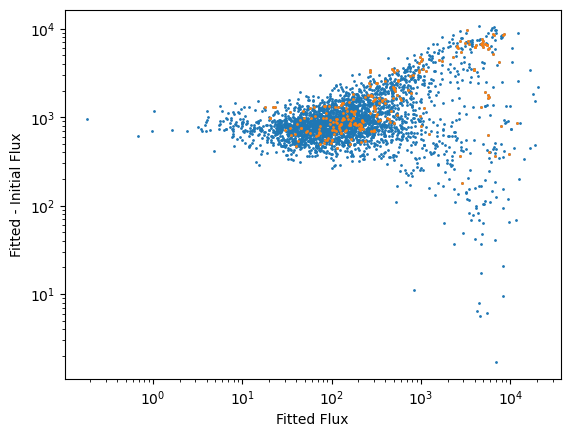

In [32]:
pl.scatter(result_biggerfootprint['flux_fit'], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init']), s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], np.abs(result_biggerfootprint['flux_fit'] - result_biggerfootprint['flux_init'])[close_neighbor_biggerfootprint], s=1)
pl.loglog()
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial Flux");

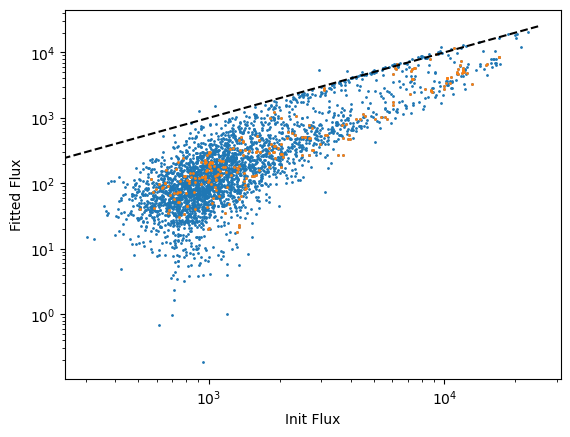

In [33]:
pl.scatter(result_biggerfootprint['flux_init'], result_biggerfootprint['flux_fit'] , s=1)
pl.scatter(result_biggerfootprint['flux_init'][close_neighbor_biggerfootprint], result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint] , s=1)
pl.xlabel("Init Flux")
pl.ylabel("Fitted Flux")
pl.loglog()
pl.plot([0,25000],[0,25000], 'k--');

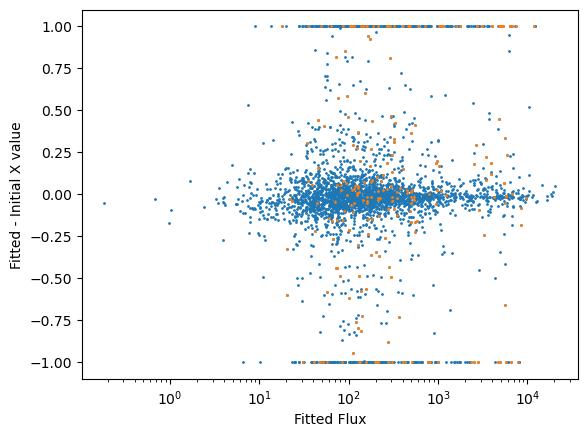

In [34]:
pl.scatter(result_biggerfootprint['flux_fit'], result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'], s=1)
pl.scatter(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], (result_biggerfootprint['x_fit'] - result_biggerfootprint['x_init'])[close_neighbor_biggerfootprint], s=1)
pl.xlabel("Fitted Flux")
pl.ylabel("Fitted - Initial X value")
pl.semilogx();

### Histograms

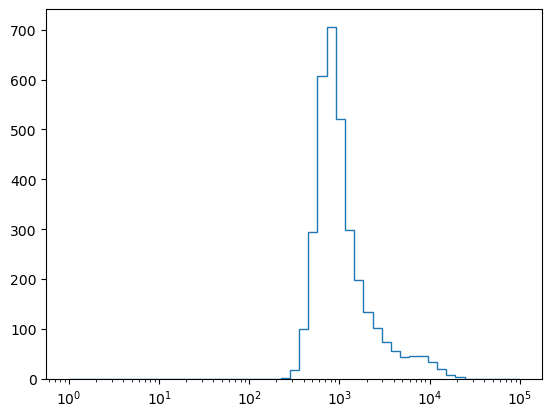

In [35]:
pl.hist(result['flux_init'], bins=np.logspace(0,5), histtype='step')
#pl.hist(result_g['flux_init'], bins=np.logspace(0,5), histtype='step')
pl.xscale('log');

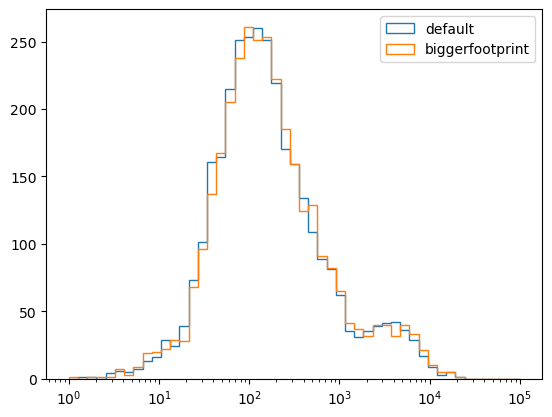

In [36]:
pl.hist(result['flux_fit'], bins=np.logspace(0,5), histtype='step', label='default')
#pl.hist(result_g['flux_fit'], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

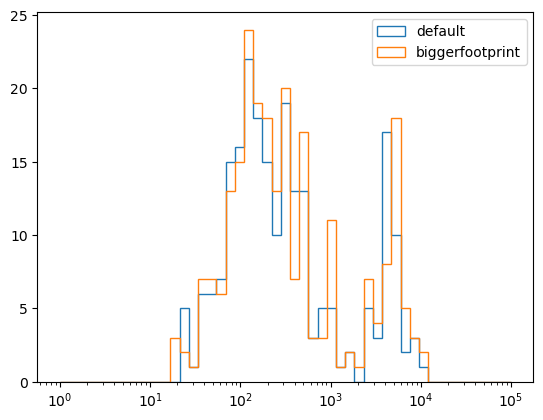

In [37]:
pl.hist(result['flux_fit'][close_neighbor], bins=np.logspace(0,5), histtype='step', label='default')
#pl.hist(result_g['flux_fit'][close_neighbor_g], bins=np.logspace(0,5), histtype='step', label='group')
pl.hist(result_biggerfootprint['flux_fit'][close_neighbor_biggerfootprint], bins=np.logspace(0,5), histtype='step', label='biggerfootprint')
pl.xscale('log');
pl.legend(loc='best');

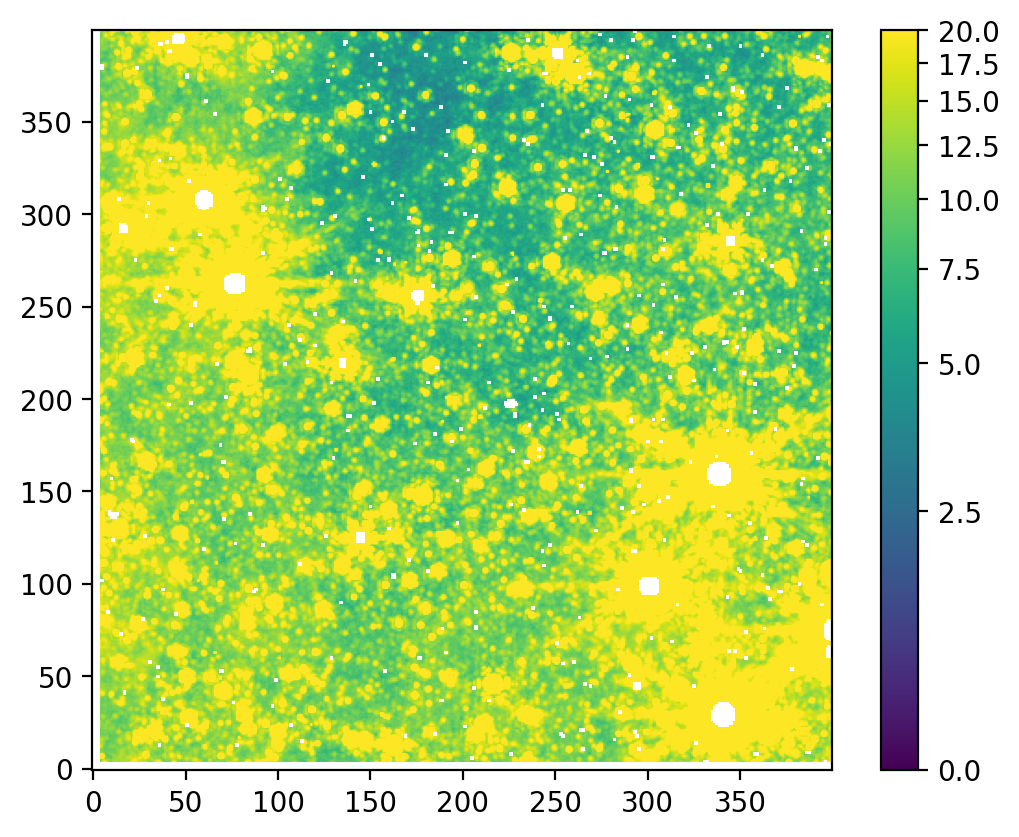

In [38]:
pl.figure(dpi=200)
pl.imshow(data, norm=simple_norm(data, min_cut=0, max_cut=20, stretch='asinh'))
pl.colorbar();

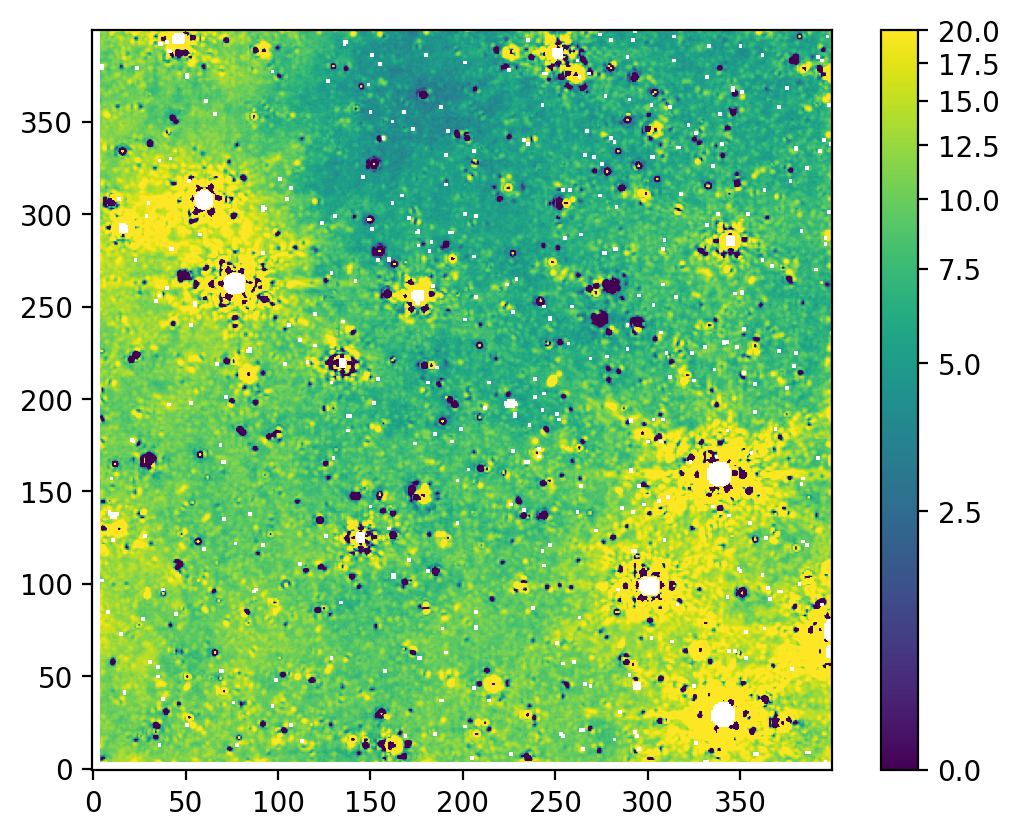

In [39]:
pl.figure(dpi=200)
pl.imshow(residual, norm=simple_norm(residual, min_cut=0, max_cut=20, stretch='asinh'))
pl.colorbar();

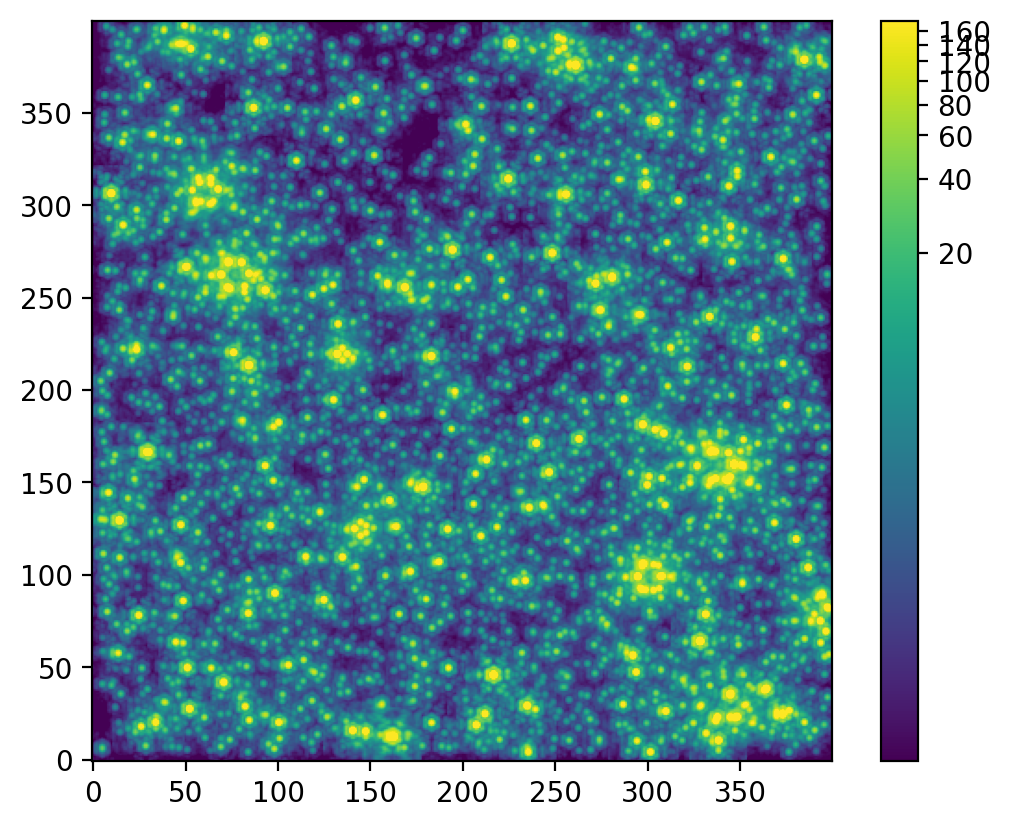

In [40]:
pl.figure(dpi=200)
pl.imshow(model, norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();

In [41]:
xl,xu,yl,yu = 100,300,200,400
slc = slice(yl,yu), slice(xl,xu)

(0.0, 200.0, 0.0, 200.0)

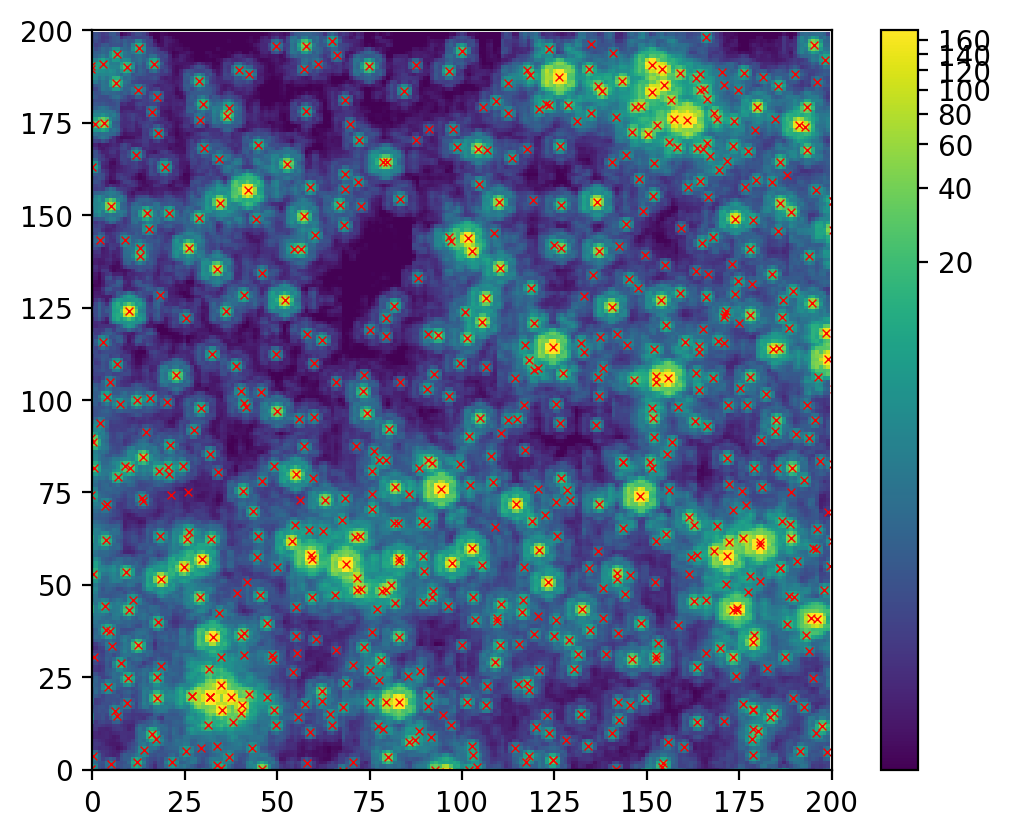

In [42]:
pl.figure(dpi=200)
pl.imshow(model[slc], norm=simple_norm(model, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200])

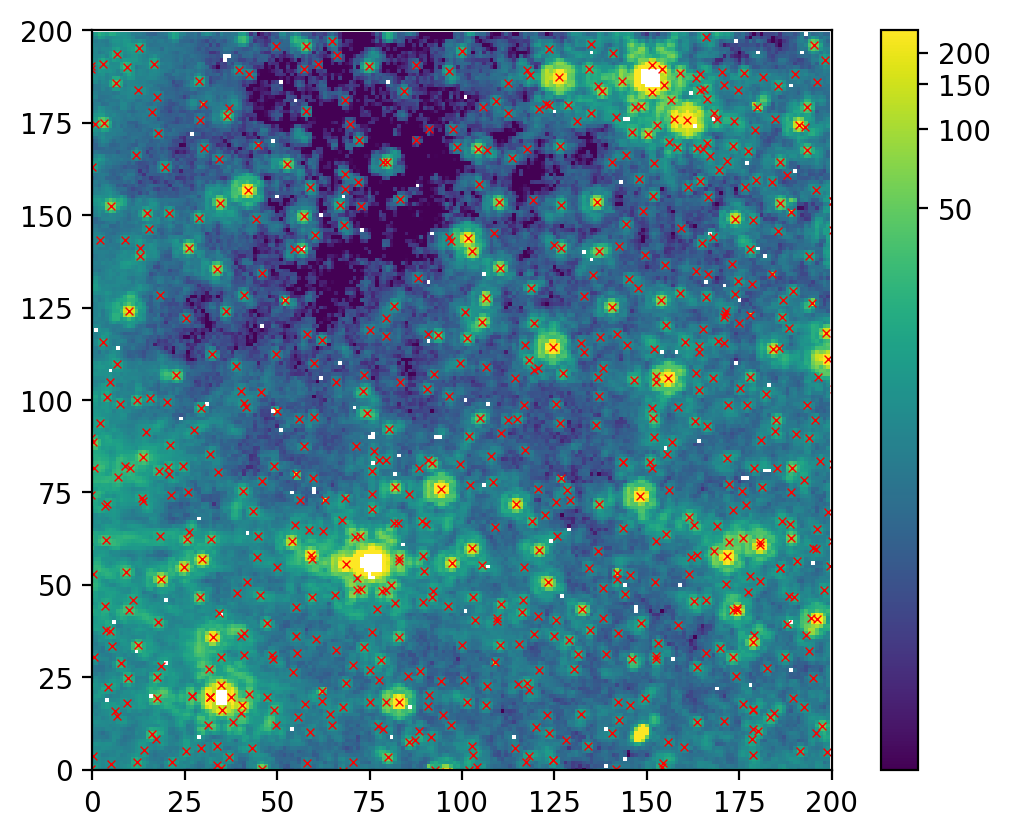

In [43]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

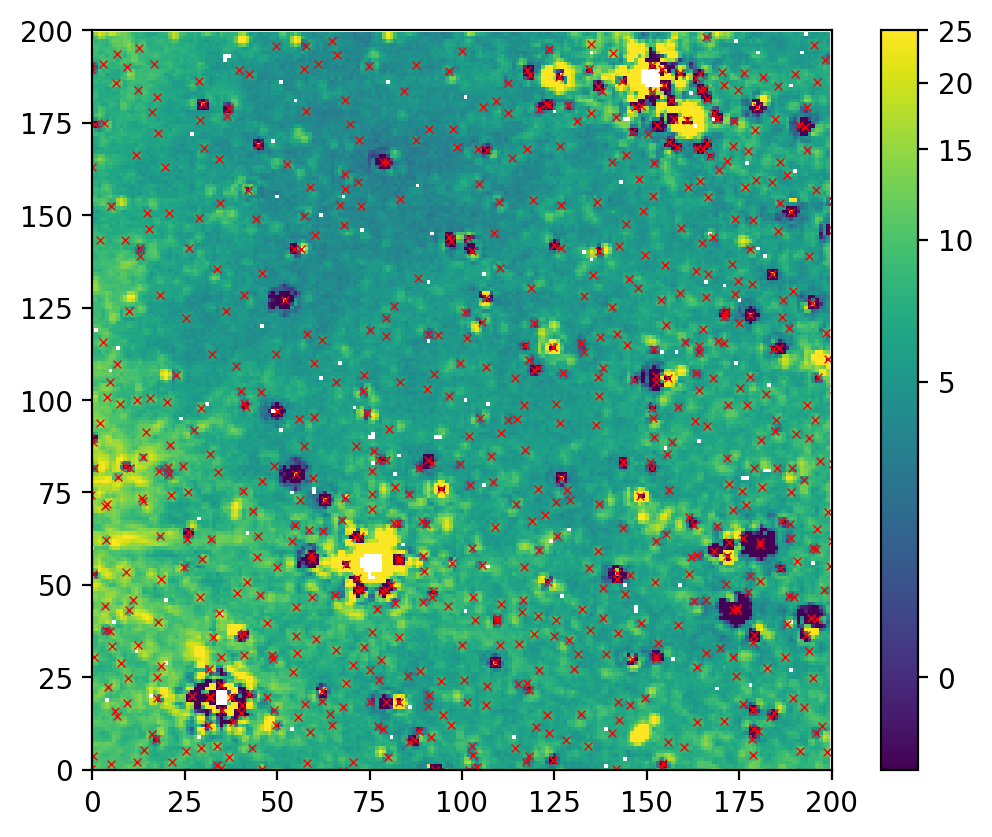

In [44]:
pl.figure(dpi=200)
pl.imshow(residual[slc], norm=simple_norm(residual, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

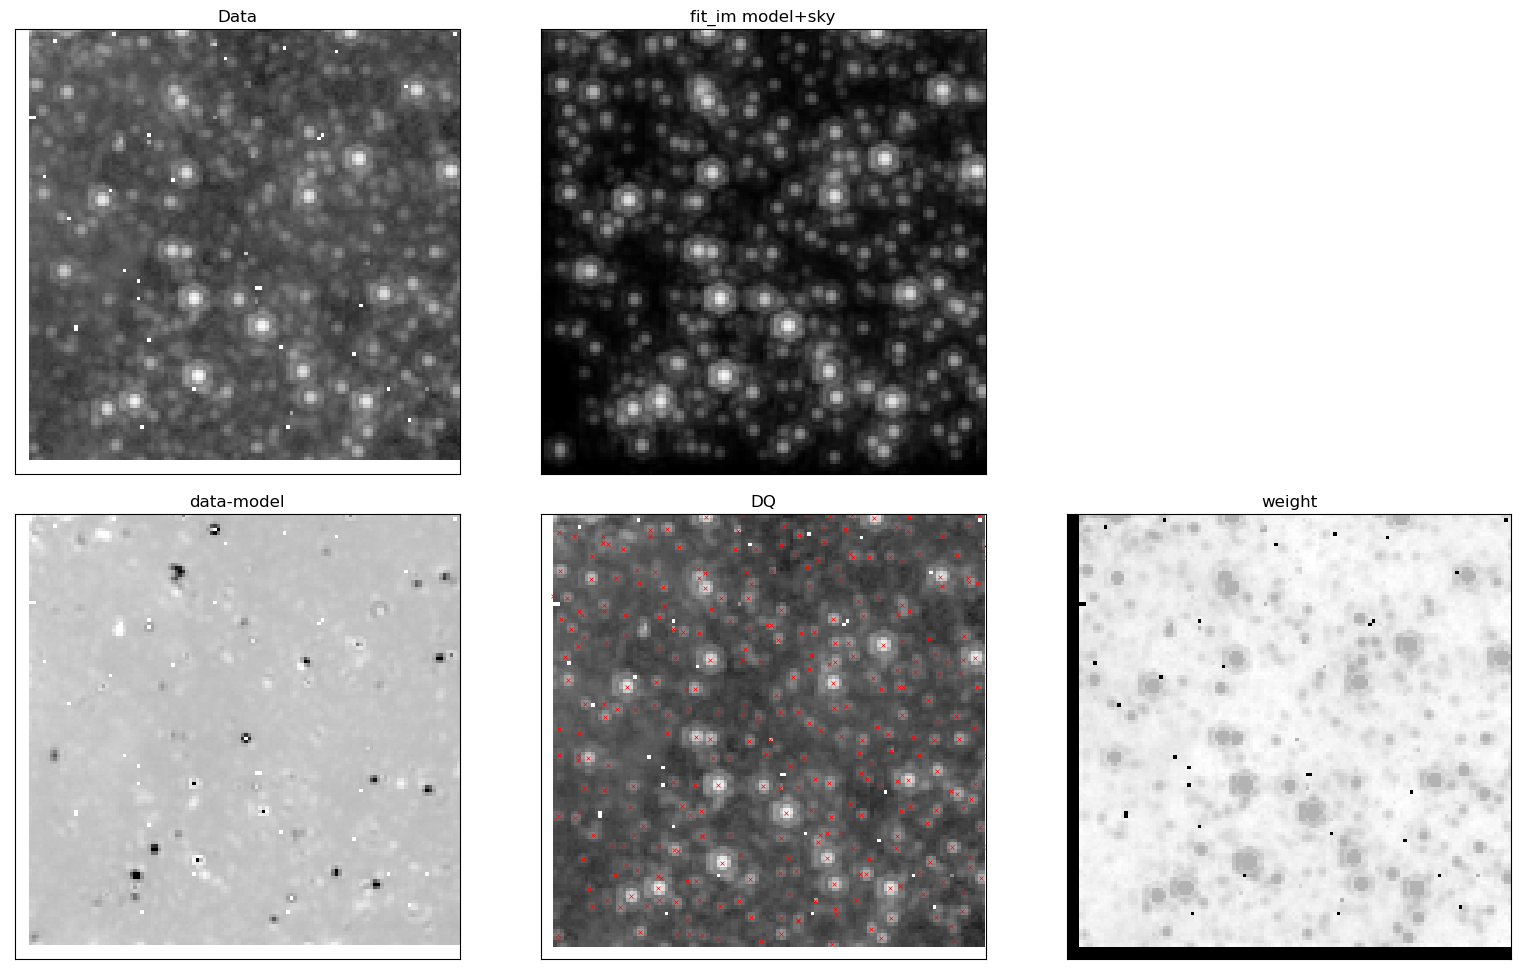

In [79]:
pl.figure(figsize=(16,10))
pl.subplot(2,3,1).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("Data")
pl.subplot(2,3,2).imshow(model[:128,:128], norm=simple_norm(model[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("fit_im model+sky")
pl.subplot(2,3,4).imshow((data-model)[:128,:128], norm=simple_norm((data-model)[:256,:256], stretch='asinh', max_percent=99.5, min_percent=0.5), cmap='gray')
pl.xticks([]); pl.yticks([]); pl.title("data-model")
pl.subplot(2,3,5).imshow(data[:128,:128], norm=simple_norm(data[:256,:256], stretch='log', max_percent=99.95, min_percent=0.5), cmap='gray')
pl.subplot(2,3,5).scatter(result['x_fit'], result['y_fit'], marker='x', color='r', s=8, linewidth=0.5)
pl.xticks([]); pl.yticks([]); pl.title("Data with result");
pl.axis([0,128,0,128])
#pl.subplot(2,3,3).imshow((dq)[:128,:128], norm=simple_norm((dq), stretch='log', min_cut=0, max_cut=5310465), cmap='jet')
#pl.subplot(2,3,3).scatter(result['x_fit'], result['y_fit'], marker='x', color='w', s=4, linewidth=0.5)
#pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("DQ");
pl.subplot(2,3,6).imshow(weight[:128,:128], norm=simple_norm(weight[:128,:128], stretch='asinh', min_percent=5, max_percent=99.95), cmap='gray')
#pl.subplot(2,3,6).scatter(result['x_fit'], result['y_fit'], marker='x', color='r', s=4, linewidth=0.5)
pl.axis([0,128,0,128])
pl.xticks([]); pl.yticks([]); pl.title("weight");
pl.suptitle("");
pl.tight_layout();

# iterative

In [61]:
phot_ = IterativePSFPhotometry(finder=daofind_tuned,
                               localbkg_estimator=LocalBackground(5, 15),
                               psf_model=dao_psf_model,
                               fitter=LevMarLSQFitter(),
                               maxiters=5,
                               fit_shape=(5, 5),
                               sub_shape=(15, 15),
                               aperture_radius=2*fwhm_pix,
                               progress_bar=True,
                               xy_bounds=1
                              )

In [62]:
print("About to do ITERATIVE photometry....")
try:
    result2 = result_iter = phot_(np.nan_to_num(data), mask=mask)
except Exception as ex:
    print(ex)
    result2 = result_iter = phot_(data)
    
#print(f"Done with ITERATIVE photometry. len(result2)={len(result2)}  dt={time.time() - t0}")
#coords2 = ww.pixel_to_world(result2['x_fit'], result2['y_fit'])

About to do ITERATIVE photometry....


Fit source/group:   0%|          | 0/2724 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/2724 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/1836 [00:00<?, ?it/s]

Objective function has encountered a non-finite value, this will cause the fit to fail!
Please remove non-finite values from your input data before fitting to avoid this error.


Fit source/group:   0%|          | 0/2724 [00:00<?, ?it/s]

Add model sources:   0%|          | 0/2724 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/1803 [00:00<?, ?it/s]

Line 1947 = self.fit_results.append(deepcopy(self._psfphot)) is commented out


Add model sources:   0%|          | 0/1803 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/835 [00:00<?, ?it/s]

Line 1947 = self.fit_results.append(deepcopy(self._psfphot)) is commented out


Add model sources:   0%|          | 0/835 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/480 [00:00<?, ?it/s]

Line 1947 = self.fit_results.append(deepcopy(self._psfphot)) is commented out


Add model sources:   0%|          | 0/480 [00:00<?, ?it/s]

Fit source/group:   0%|          | 0/394 [00:00<?, ?it/s]

Line 1947 = self.fit_results.append(deepcopy(self._psfphot)) is commented out


In [63]:
residual_iter = phot_.make_residual_image(data, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/2724 [00:00<?, ?it/s]

In [64]:
model_iter = phot_.make_model_image(data.shape, (31, 31), include_localbkg=False)

Add model sources:   0%|          | 0/2724 [00:00<?, ?it/s]

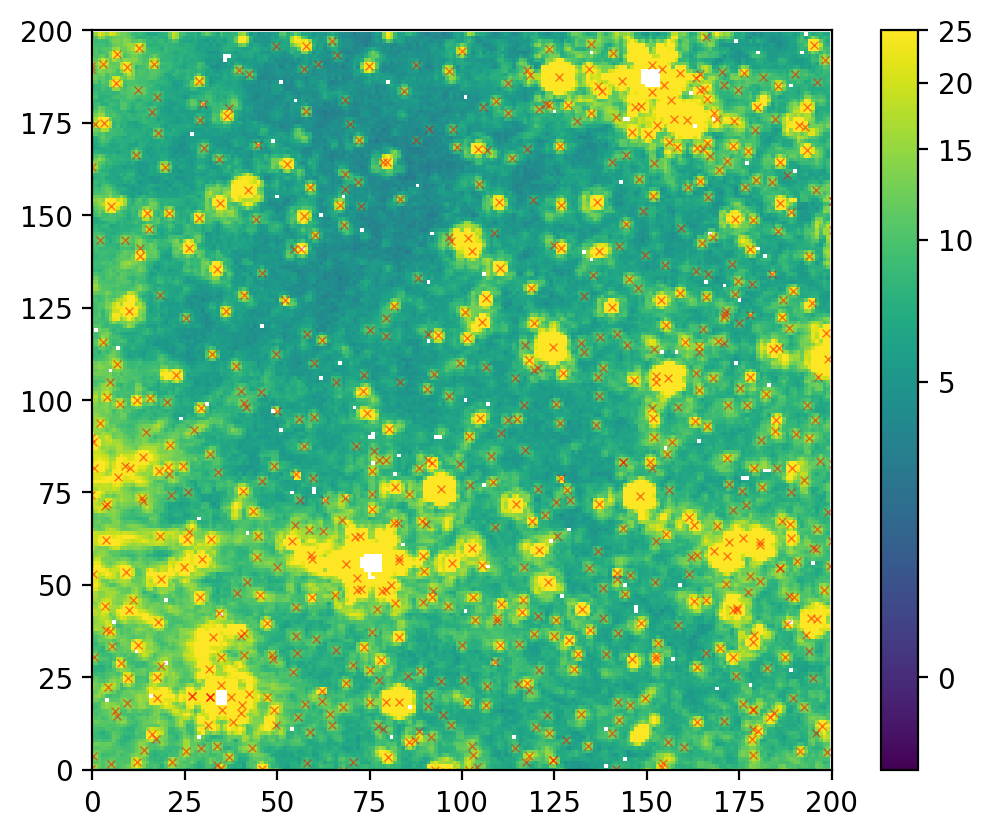

In [65]:
pl.figure(dpi=200)
pl.imshow(data[slc], norm=simple_norm(data, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8, alpha=0.5)
pl.axis([0,200,0,200]);

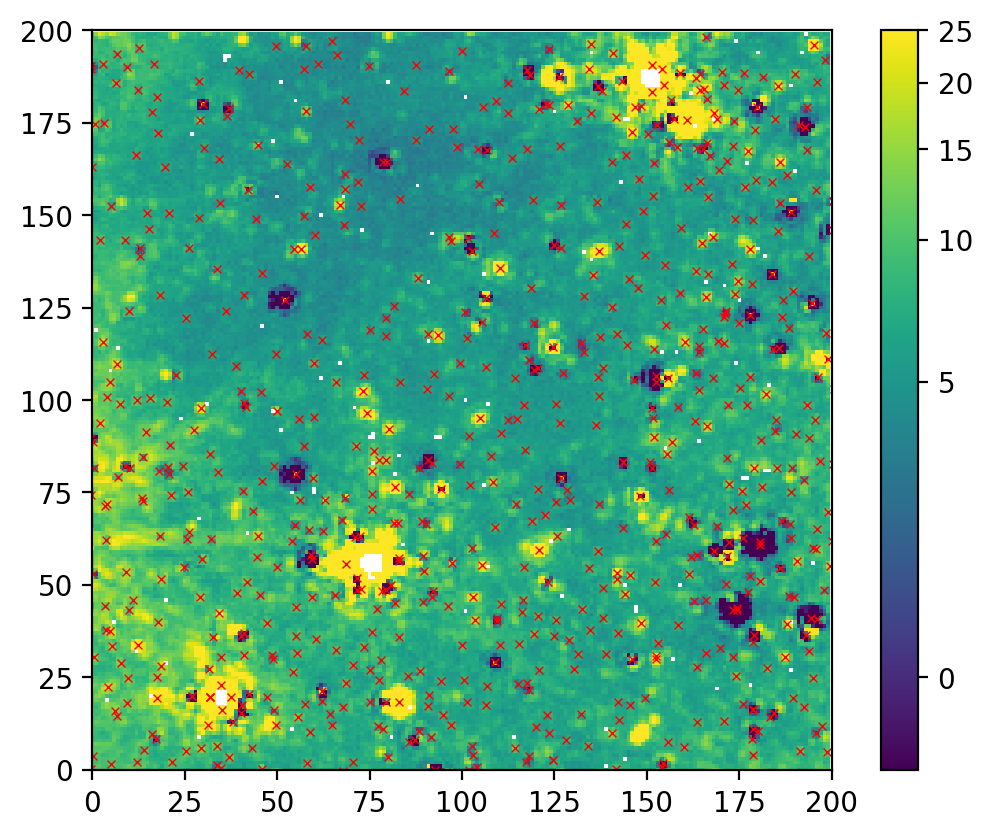

In [66]:
pl.figure(dpi=200)
pl.imshow(residual_iter[slc], norm=simple_norm(residual_iter, min_cut=-1, max_cut=25, stretch='asinh'))
pl.colorbar();
pl.scatter(result['x_fit']-xl, result['y_fit']-yl, marker='x', color='r', linewidths=0.5, s=8)
pl.axis([0,200,0,200]);

# iterative grouped

# Residual zoom

In [67]:
import sys
sys.path.append(f'{basepath}/analysis')
import plot_tools
import importlib as imp
imp.reload(plot_tools)
from plot_tools import diagnostic_stamps_by_mag_dao
def diagnostic_stamps_by_mag(*args, **kwargs):
    return diagnostic_stamps_by_mag_dao(*args, filtername=filtername, pixel_area=ww.celestial.proj_plane_pixel_area(), data=data, **kwargs)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


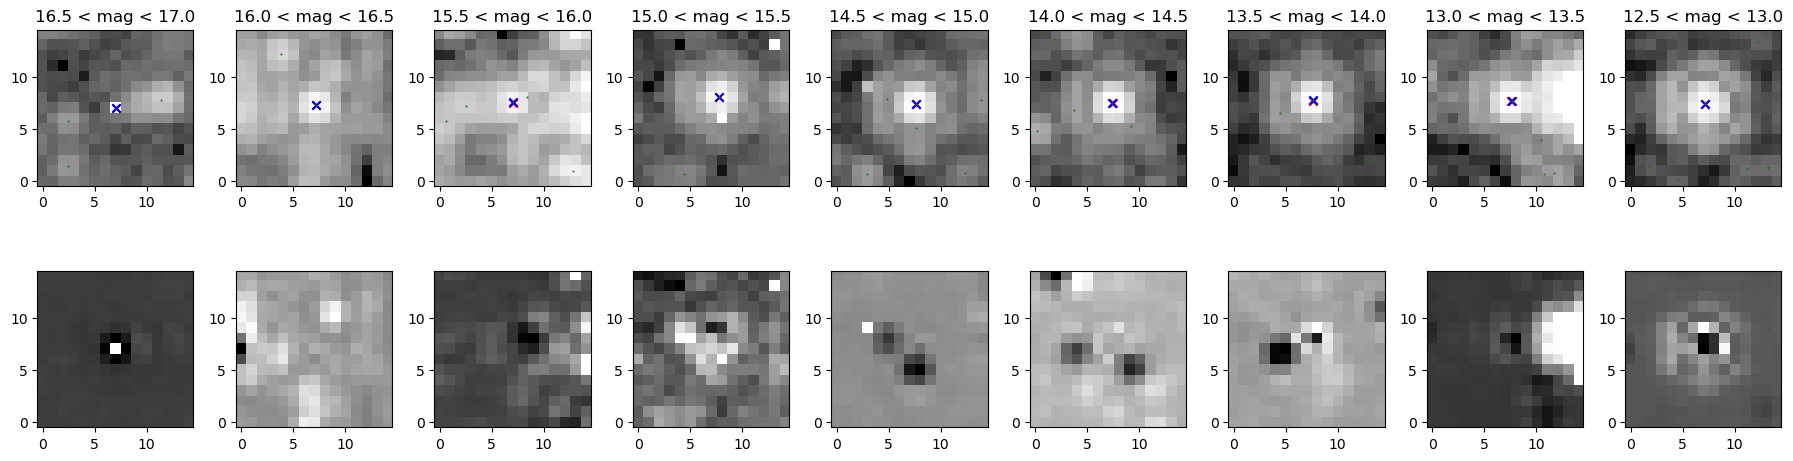

In [68]:
diagnostic_stamps_by_mag(result, residual)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


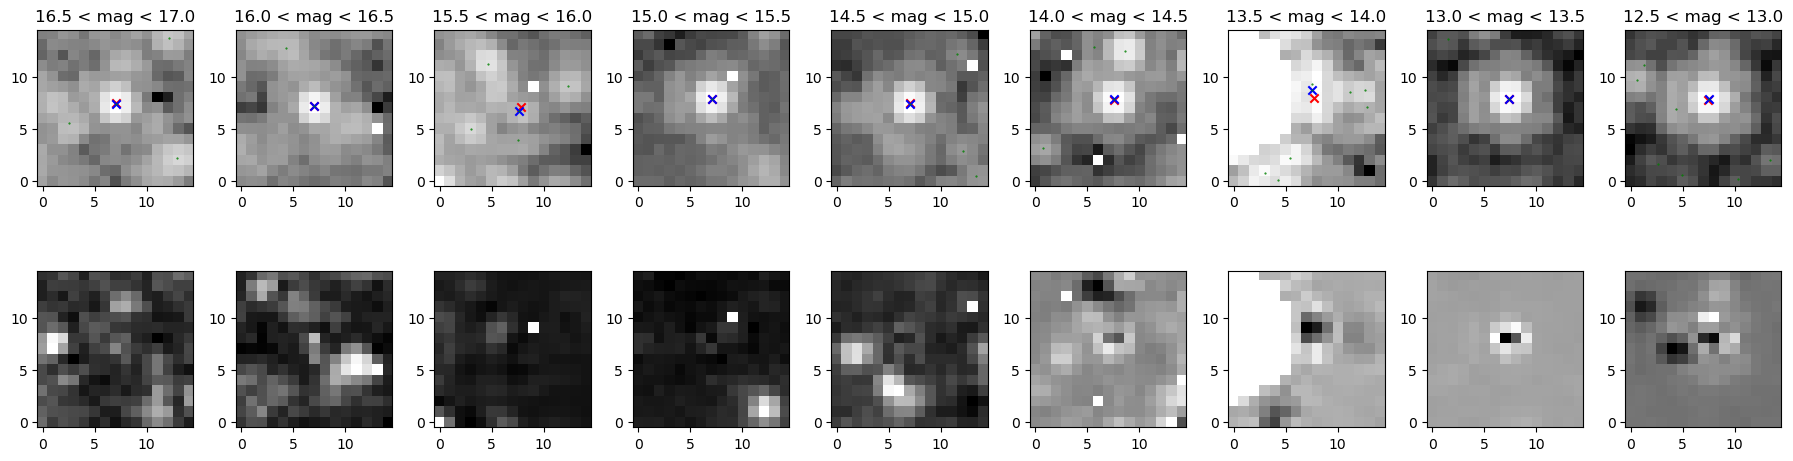

In [69]:
diagnostic_stamps_by_mag(result, residual, ind_offset=1)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


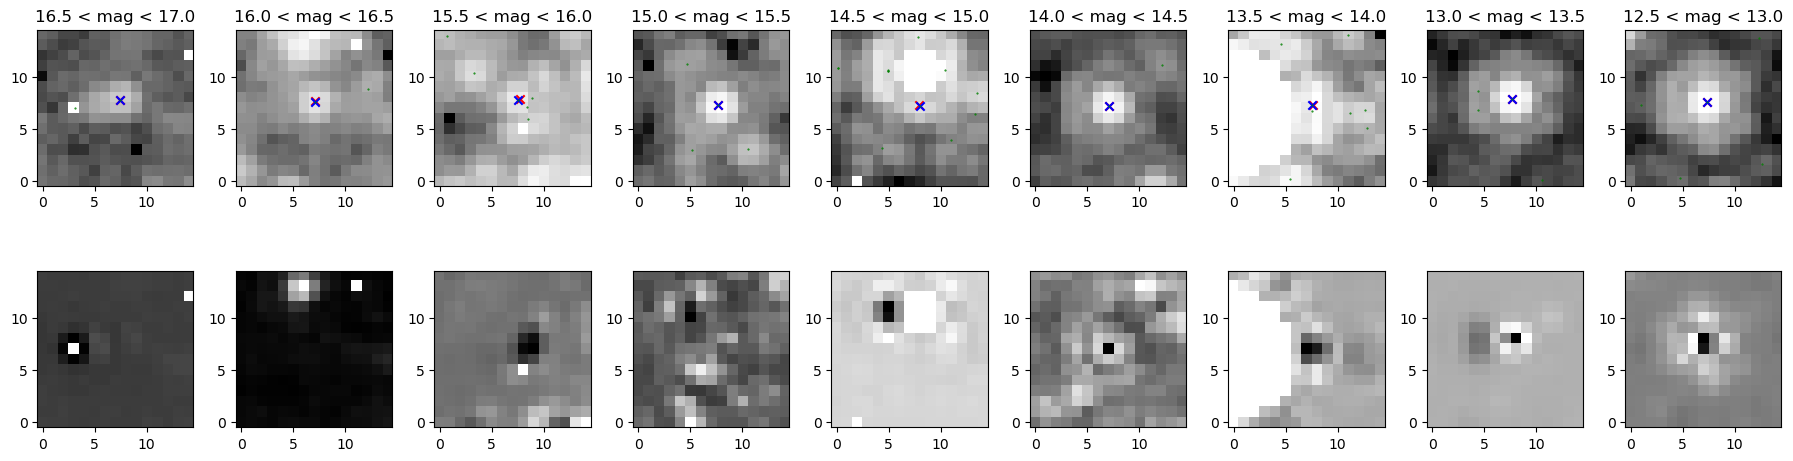

In [70]:
diagnostic_stamps_by_mag(result, residual, ind_offset=2)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


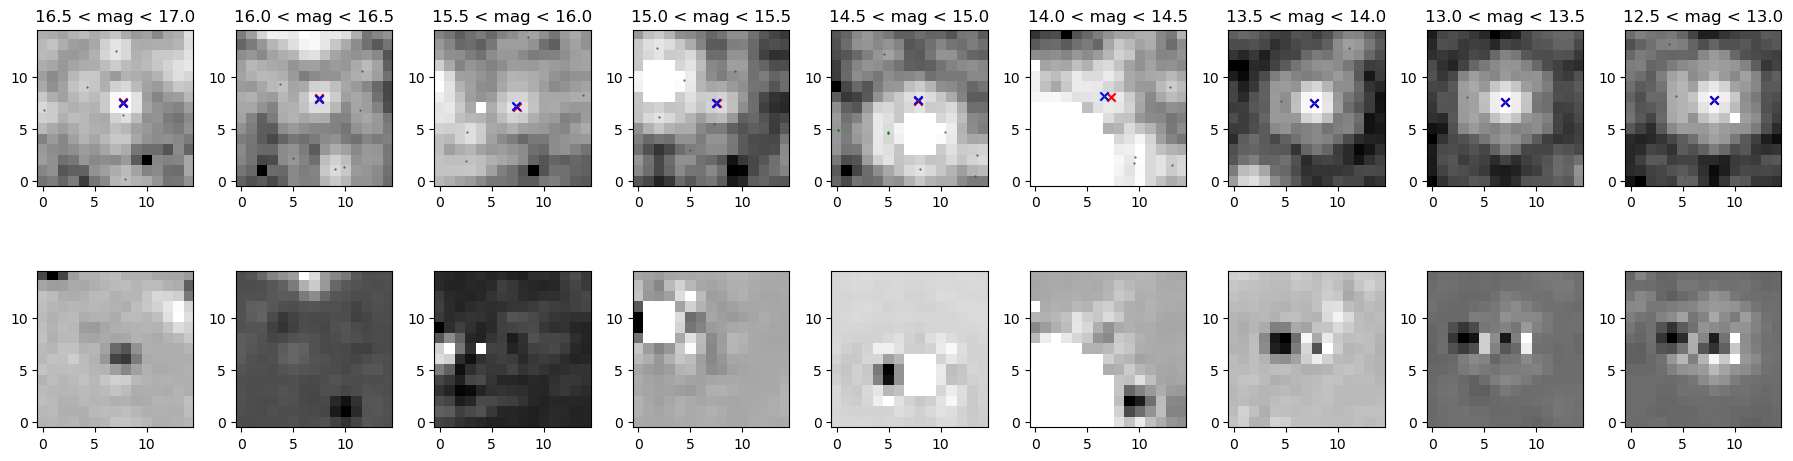

In [71]:
diagnostic_stamps_by_mag(result, residual, ind_offset=3)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


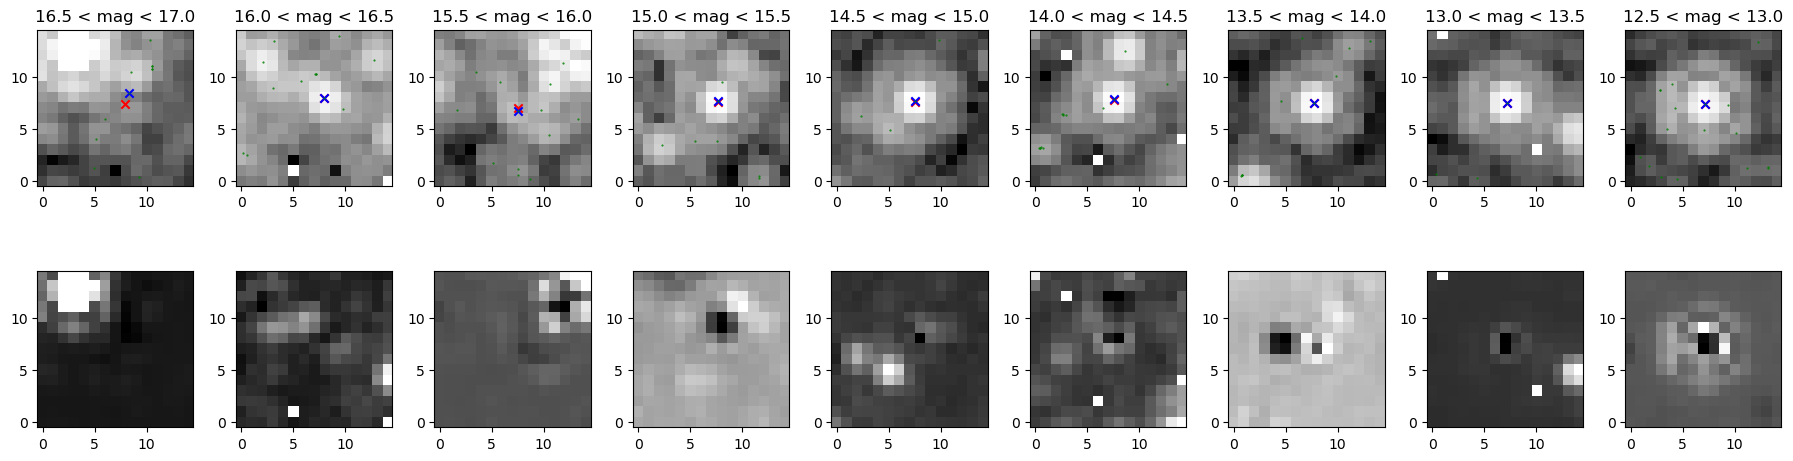

In [73]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=0)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


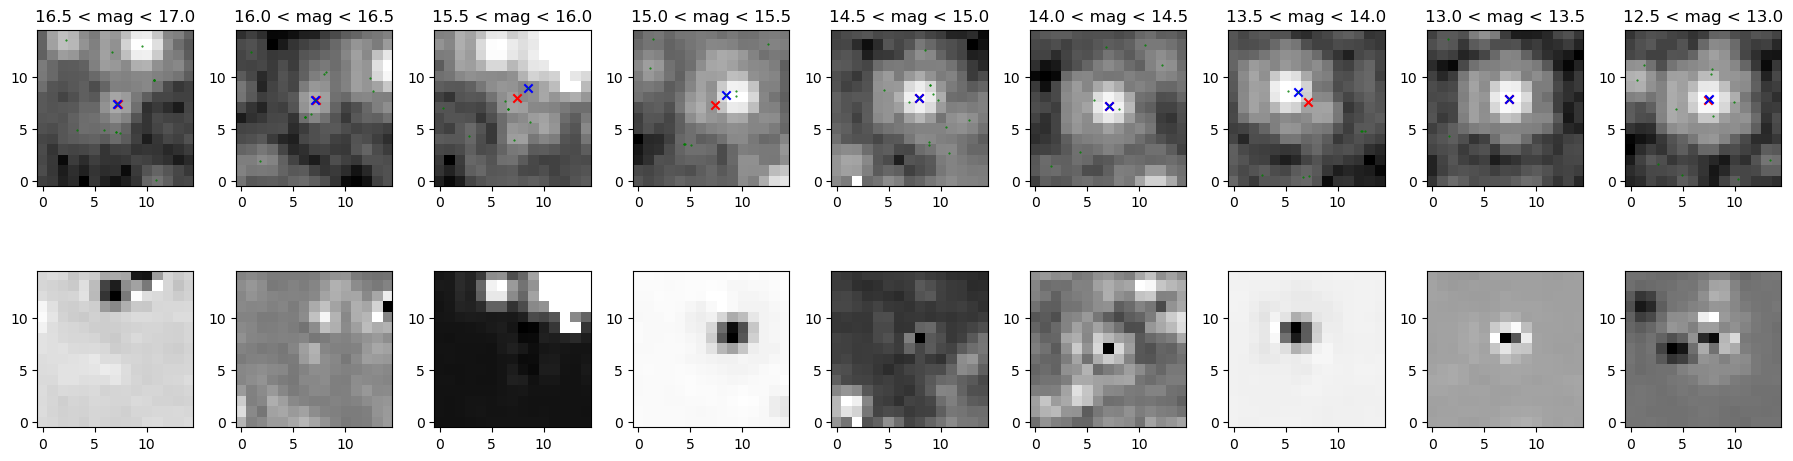

In [74]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=1)

/blue/adamginsburg/adamginsburg/repos/astropy/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in log10
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


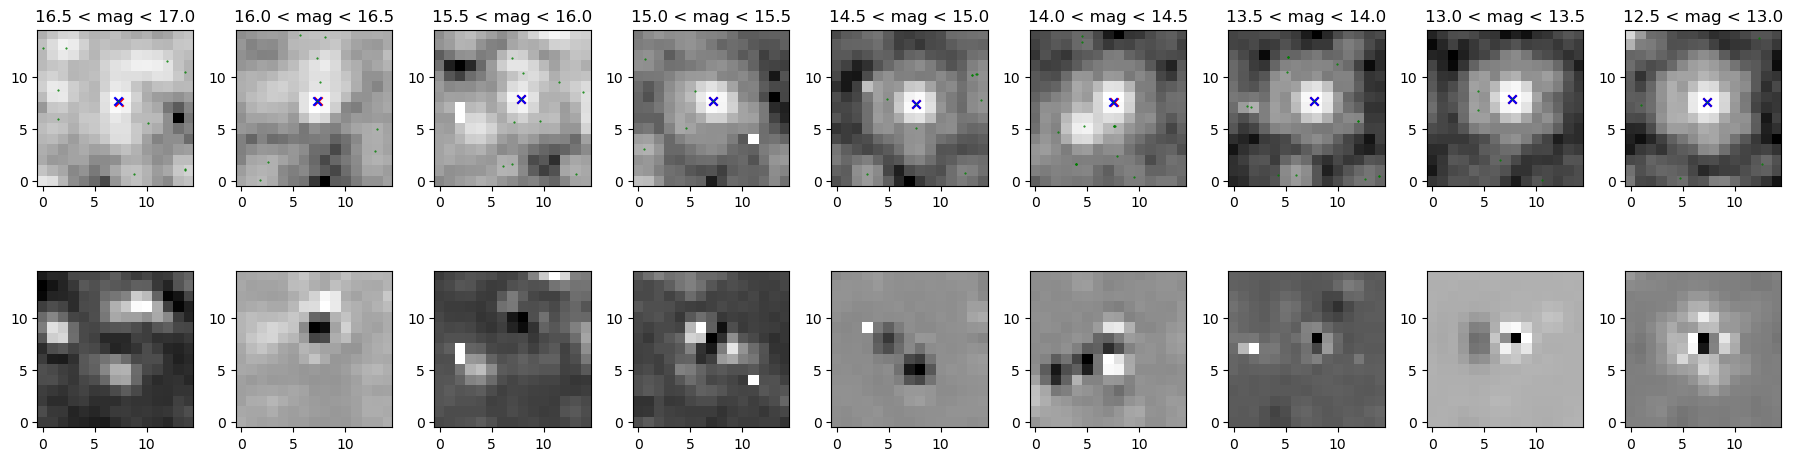

In [75]:
diagnostic_stamps_by_mag(result_iter, residual_iter, ind_offset=2)